# Evaluación del caso “Binaria + planeta cerca del radio de Hill”

En esta sección medimos cómo afecta la optimización al exponente de Lyapunov del sistema.  
Partimos de un estado base (masas en el centro de sus `mass_bounds`) para obtener un λ de referencia y lo comparamos con el mejor individuo que devolvió el GA.  
Luego integramos la trayectoria con las masas óptimas y visualizamos el comportamiento de los tres cuerpos, poniendo especial atención a los encuentros cercanos del “planeta” con el binario.

> **Interpretación**
> - Un λ más pequeño indica una dinámica menos caótica.
> - El gráfico permite comprobar si el planeta logra mantenerse en órbita o si termina inestable por la proximidad al radio de Hill.


## Preparación del entorno
Aseguramos que el directorio raíz del proyecto esté disponible en `sys.path` para poder importar los módulos internos sin problemas, independientemente de desde dónde se ejecute el notebook.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias principales
Importamos los componentes clave del pipeline:
- `Config` y utilidades de seeding.
- El controlador híbrido (GA + refinamiento).
- Herramientas de visualización y simulación REBOUND.
- `numpy` para cualquier análisis adicional.


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path  # 


In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


In [ ]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="DEBUG")
logger.handlers.clear()
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)


## Configuración del escenario “Binaria + planeta cerca del radio de Hill”
Definimos la escena de estudio:
- Dos estrellas de masas distintas orbitando el baricentro.
- Un planeta tipo Júpiter ubicado cerca del radio de Hill.
- Hiperparámetros del GA y de la fase continua orientados a detectar combinaciones de masas que mitiguen el caos.


In [ ]:
# ["Binaria con planeta (Hill) – órbita periódica"]
case = {
    # Simulación (UA, años, masas solares)
    "t_end_short": 0.5,
    "t_end_long": 4.0,
    "dt": 0.0002,
    "integrator": "ias15",
    "r0": (
        (-0.09, 0.0, 0.0),
        (0.11, 0.0, 0.0),
        (0.52, 0.0, 0.0),
    ),
    "v0": (
        (0.0, 8.9411294392, 0.0),
        (0.0, -10.9280470924, 0.0),
        (0.0, 12.3223401880, 0.0),
    ),

    # Parámetros físicos (masas solares)
    "mass_bounds": (
        (0.9, 1.2),
        (0.7, 1.0),
        (8.5e-4, 1.2e-3),
    ),
    "G": 39.47841760435743,
    "x0": (-0.09, 0.0, 0.0, 8.94, 0.11, 0.0, 0.0, -10.93),
    "periodicity_weight": 500.0,

    # Algoritmo genético
    "pop_size": 180,
    "n_gen_step": 5,
    "crossover": 0.9,
    "mutation": 0.2,
    "selection": "tournament",
    "elitism": 2,
    "seed": 9871,

    # Optimización continua
    "max_epochs": 50,
    "top_k_long": 12,
    "stagnation_window": 6,
    "stagnation_tol": 1.25e-4,
    "local_radius": 0.04,
    "radius_decay": 0.85,
    "time_budget_s": 1800.0,
    "eval_budget": 16000,

    # Backend / cache
    "use_gpu": "false",
    "batch_size": 96,
    "cache_exact_max": 600,
    "cache_approx_max": 1800,

    # I/O
    "artifacts_dir": "artifacts/hill_planet_periodic",
    "save_plots": True,
    "headless": False,
}


In [6]:
from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

cfg = Config(**case)
logger = setup_logger()

In [7]:
from two_body.simulation.rebound_adapter import ReboundSim
from two_body.simulation.lyapunov import LyapunovEstimator

masses = tuple(np.mean(bounds) for bounds in cfg.mass_bounds)
sim = ReboundSim(G=cfg.G, integrator=cfg.integrator).setup_simulation(
    masses, cfg.r0[:len(masses)], cfg.v0[:len(masses)]
)
estimator = LyapunovEstimator()
ret = estimator.mLCE({"sim": sim, "dt": cfg.dt, "t_end": cfg.t_end_short, "masses": masses})
print(ret)


{'lambda': 0.9142204128931353, 'series': None, 'meta': {'steps': 2500, 'dt': 0.0002, 'n_bodies': 3, 'masses': (1.05, 0.85, 0.0010249999999999999), 'impl': 'rebound_megno'}}


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
import logging
import importlib

from two_body.core.telemetry import setup_logger
import two_body.logic.fitness as fitness_mod

importlib.reload(fitness_mod)                # recoge el código nuevo
from two_body.logic.fitness import FitnessEvaluator  # vuelve a importar la clase

logger = setup_logger(level="INFO")         # asegura nivel INFO
logger.setLevel(logging.INFO)
for handler in logger.handlers:
    handler.setLevel(logging.INFO)


## Ejecución del optimizador
Inicializamos el controlador con la configuración anterior, habilitamos el registro de eventos y lanzamos el proceso completo de optimización. Al finalizar, presentamos los logs capturados junto con el resultado agregado (mejor combinación de masas encontrada y métricas básicas).

In [9]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.9, 1.2), (0.7, 1.0), (0.00085, 0.0012)) 50 16000


In [10]:
with time_block("notebook_run", extra={"source": "Caso01.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-11-02 18:03:21,228] INFO - Starting optimization | pop=180 | dims=3 | time_budget=1800.0s | eval_budget=16000
[2025-11-02 18:03:34,262] INFO - Epoch 0 | new global best (short) lambda=3.001726 | fitness=-1380.676116 | penalty=2.755349 | masses=(1.066355, 0.701437, 0.000897)
[2025-11-02 18:03:40,876] INFO - Epoch 0 complete | lambda_short=3.001726 | fitness_short=-1380.676116 | lambda_best=3.001726 | fitness_best=-1380.676116 | evals short/long=180/12 | total evals=192 | radius=0.0400
[2025-11-02 18:03:54,120] INFO - Epoch 1 | new global best (short) lambda=4.474038 | fitness=-1338.912969 | penalty=2.668878 | masses=(1.066355, 0.701367, 0.000897)
[2025-11-02 18:04:01,092] INFO - Epoch 1 complete | lambda_short=4.474038 | fitness_short=-1338.912969 | lambda_best=4.474038 | fitness_best=-1338.912969 | evals short/long=180/12 | total evals=384 | radius=0.0400
[2025-11-02 18:04:21,390] INFO - Epoch 2 complete | lambda_short=-0.623173 | fitness_short=-2376.415188 | lambda_best=4.474038

In [11]:
metrics = controller.metrics


In [12]:
results

{'status': 'completed',
 'best': {'masses': [1.0657623599327009, 0.7, 0.0012],
  'lambda': -3.239193647667314,
  'fitness': -149.42427240406374,
  'm1': 1.0657623599327009,
  'm2': 0.7,
  'm3': 0.0012},
 'evals': 9600,
 'epochs': 50}

## Evaluación comparativa y visualización
Contrastamos el exponente de Lyapunov del estado base (masas en la mitad de sus rangos) contra el obtenido por la solución optimizada. Por último, integramos la dinámica con las masas ganadoras para visualizar la trayectoria de los tres cuerpos y observar el comportamiento cerca del límite de estabilidad.


In [ ]:
from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

original_masses = (1.3, 0.8, 1.3e-3)
center = original_masses
#center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)

baseline_fits, baseline_details = evaluator.evaluate_batch(
    [center],
    horizon="long",
    return_details=True,
)
baseline_fit = baseline_fits[0]
baseline_lambda = baseline_details[0].get("lambda")
if baseline_lambda is None or not np.isfinite(baseline_lambda):
    baseline_lambda = -baseline_fit

best_payload = results.get("best", {})
best_fit = best_payload.get("fitness")
best_lambda = best_payload.get("lambda")
if best_lambda is None and best_fit is not None:
    best_lambda = -best_fit

print(
    f"lambda inicial = {baseline_lambda:.6f}, "
    f"lambda optimo = {best_lambda if best_lambda is not None else 'N/A'}"
)


lambda inicial = inf, lambda optimo = -3.239193647667314


In [ ]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
print("Trayectoria calculada con masas óptimas.")
print(traj.shape)
print(traj[-1])
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


Trayectoria calculada con masas óptimas.
(20000, 3, 6)
[[-7.94563536e-02  1.97791068e-03  0.00000000e+00  1.57399352e-01
   7.87035237e+00  0.00000000e+00]
 [ 1.20484527e-01 -2.27845080e-03  0.00000000e+00 -2.55086583e-01
  -1.19951183e+01  0.00000000e+00]
 [ 2.85351464e-01 -4.27555995e-01  0.00000000e+00  9.00858668e+00
   7.21460124e+00  0.00000000e+00]]


In [15]:
from two_body.scripts.demo_tierra import (
    summarize_trajectory,
    compute_total_energy,
    estimate_orbital_period,
)

summarize_trajectory(
    logger=logger,
    traj=traj,
    masses=best_masses,
    cfg=cfg,
)

[2025-11-02 18:22:13,267] INFO - Resumen de simulacion
[2025-11-02 18:22:13,267] INFO -   pasos=20000 | dt=0.000200 anos | duracion total=4.000 anos
[2025-11-02 18:22:13,267] INFO -   masas=(1.0657623599327009, 0.7, 0.0012) (M_sun) | G=39.478418
[2025-11-02 18:22:13,286] INFO -   centro de masa: desplazamiento maximo = 3.282e-15 UA
[2025-11-02 18:22:13,301] INFO -   cuerpo 0 -> radio[min, max]=[0.0789, 0.1039] UA | radio sigma=8.5570e-03 | velocidad media=6.8623 UA/ano
[2025-11-02 18:22:13,314] INFO -   cuerpo 1 -> radio[min, max]=[0.1204, 0.1579] UA | radio sigma=1.2985e-02 | velocidad media=10.4479 UA/ano
[2025-11-02 18:22:13,314] INFO -   cuerpo 2 -> radio[min, max]=[0.4284, 0.5516] UA | radio sigma=3.7966e-02 | velocidad media=12.1414 UA/ano
[2025-11-02 18:22:13,381] INFO -   energia total (media)=-6.395075e+01 | variacion relativa=2.111e-15
[2025-11-02 18:22:13,389] INFO -   periodo orbital estimado para la Tierra ~= 0.083303 anos
[2025-11-02 18:22:13,389] INFO -   error relativo 

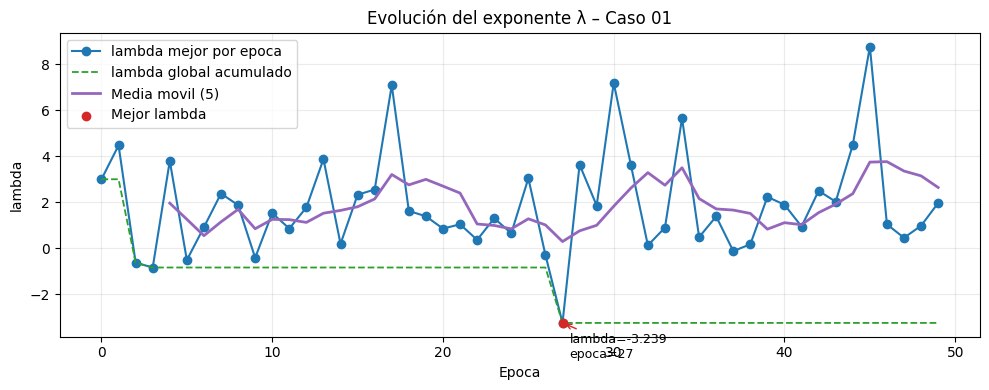

In [16]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 01",
    moving_average_window=5,   # opcional
)

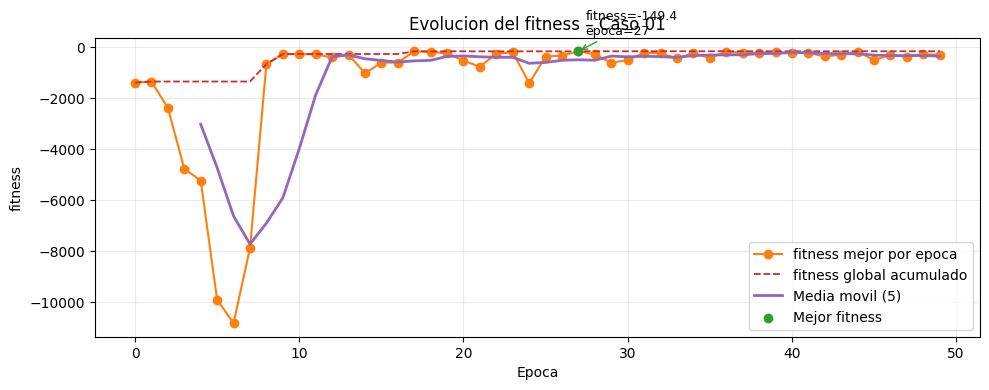

In [17]:
_ = viz_3d.plot_fitness_evolution(
    fitness_history=metrics.best_fitness_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolucion del fitness – Caso 01",
    moving_average_window=5,
)


In [18]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


In [ ]:
sim_orig = sim_builder.setup_simulation(center, r0, v0)
traj_original = sim_builder.integrate(sim_orig, t_end=cfg.t_end_long, dt=cfg.dt)

traj_opt = traj


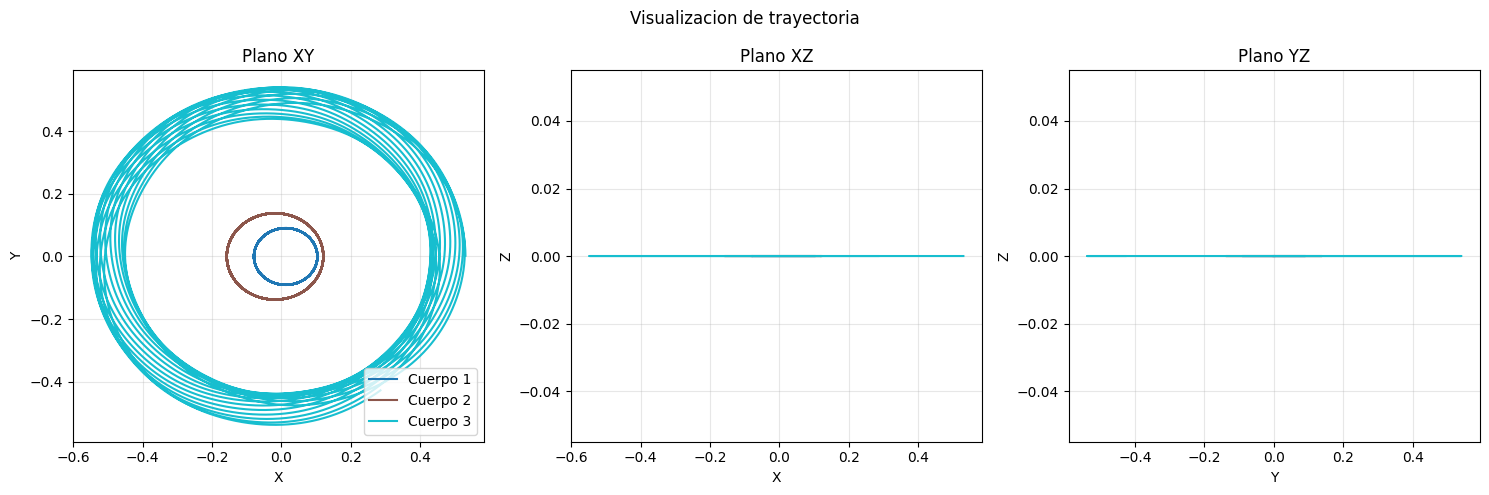

In [20]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks)  # usa una asignación para que Jupyter no duplique la figura

In [21]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # MB

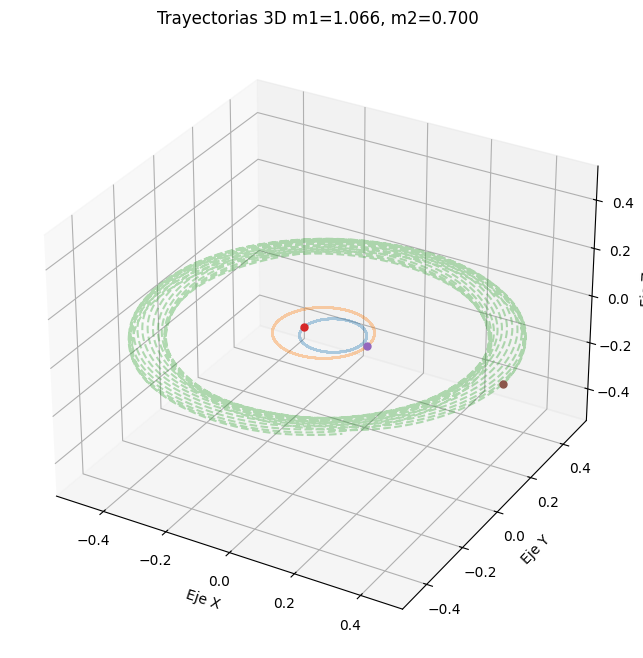

In [22]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

In [ ]:
from matplotlib.animation import FFMpegWriter

writer = FFMpegWriter(fps=1000 // 50, bitrate=2400)   # fps = 1000/interval_ms
output_path = Path("artifacts/caso01")
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

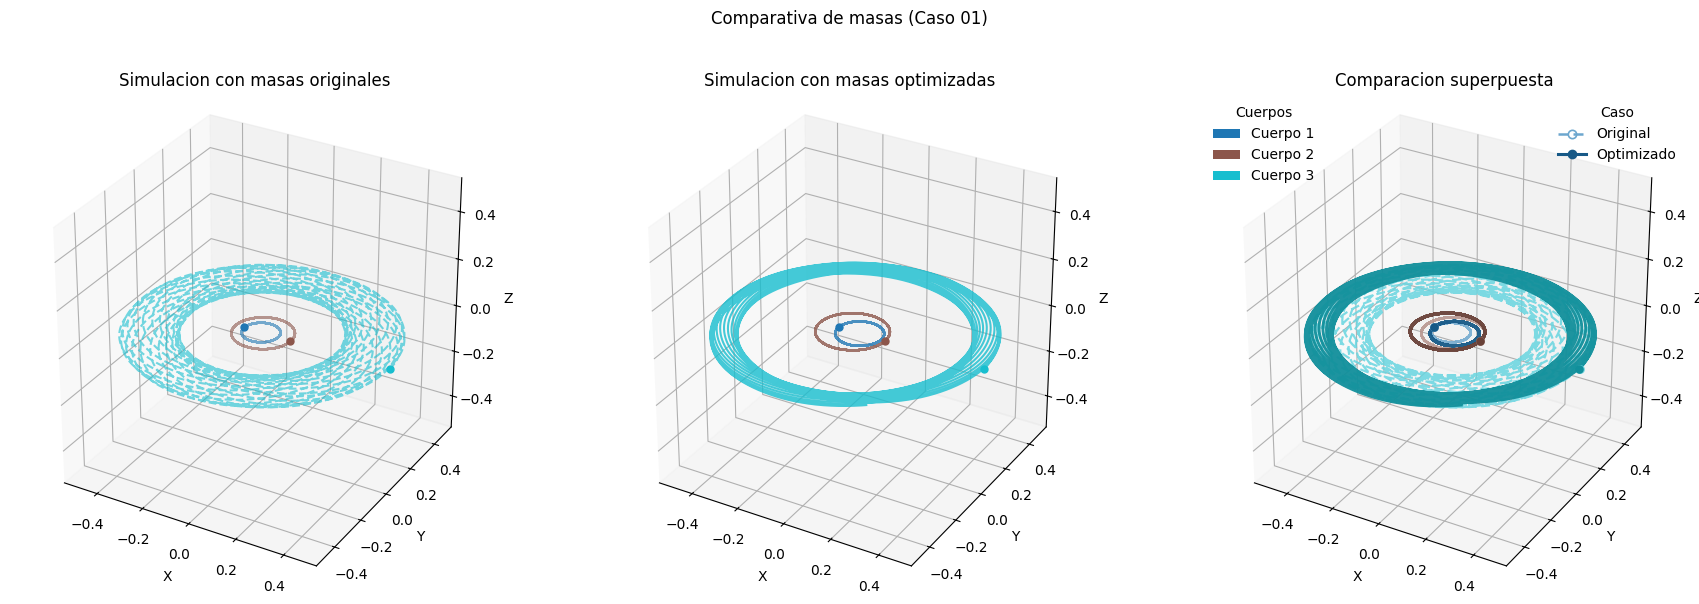

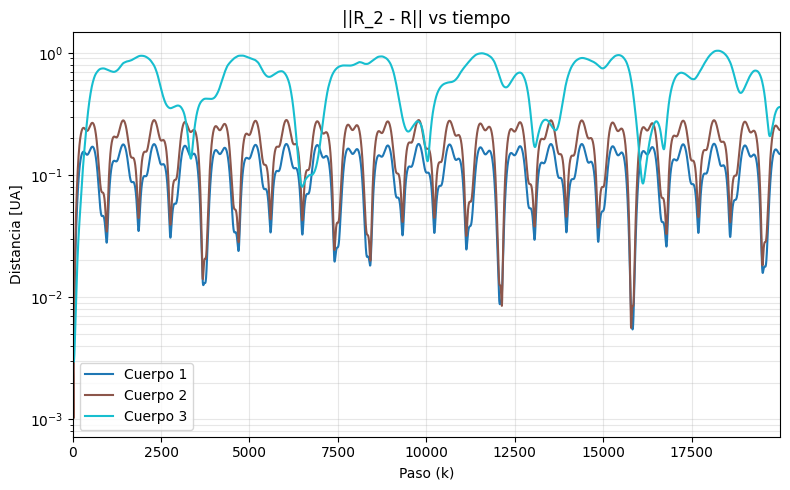

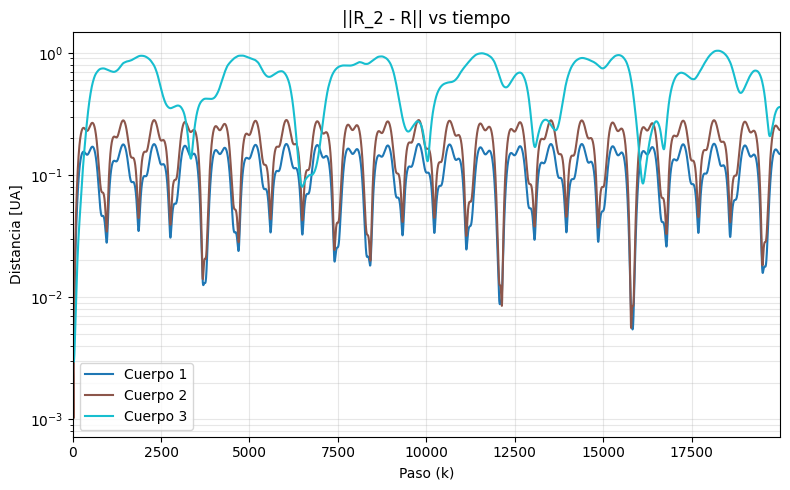

In [ ]:
orig_tracks = [traj_original[:, i, :3] for i in range(traj_original.shape[1])]
opt_tracks = [traj_opt[:, i, :3] for i in range(traj_opt.shape[1])]

anim_mass = viz_3d.plot_mass_comparison(
    original_tracks=orig_tracks,
    optimized_tracks=opt_tracks,
    original_masses=center,
    optimized_masses=best_masses,
    body_labels=[f"Cuerpo {i+1}" for i in range(len(opt_tracks))],
    dt=cfg.dt,
    title="Comparativa de masas (Caso 01)",
)

if anim_mass is not None:
    dist_fig = viz_3d.plot_mass_distance_evolution(
        comparison_data=anim_mass.mass_comparison_data,
        title="||R_2 - R|| vs tiempo",
    )
    if dist_fig is not None:
        display(dist_fig)
    # display(HTML(anim_mass.to_jshtml()))  # descomenta para ver la animación embebida


In [25]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

In [26]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

'Usando CSV: C:\\Users\\emicr\\Documents\\CODIGOS_FUENTES\\TrabajoTerminal\\collision_of_two_bodies\\two_body\\data\\timings\\timings_ddf0b833-a5c4-4572-b8c0-19a388d2f328_20251103_000322.csv'

MemoryError: Unable to allocate 264. MiB for an array with shape (34582848,) and data type uint64

Ejecutando: c:\Users\emicr\anaconda3\envs\grav2body\python.exe scripts/plot_timings.py --run-id a0bcc2fe-d385-4864-91e1-54134af044d2 --top-n 5
Graficas guardadas en C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies\two_body\reports




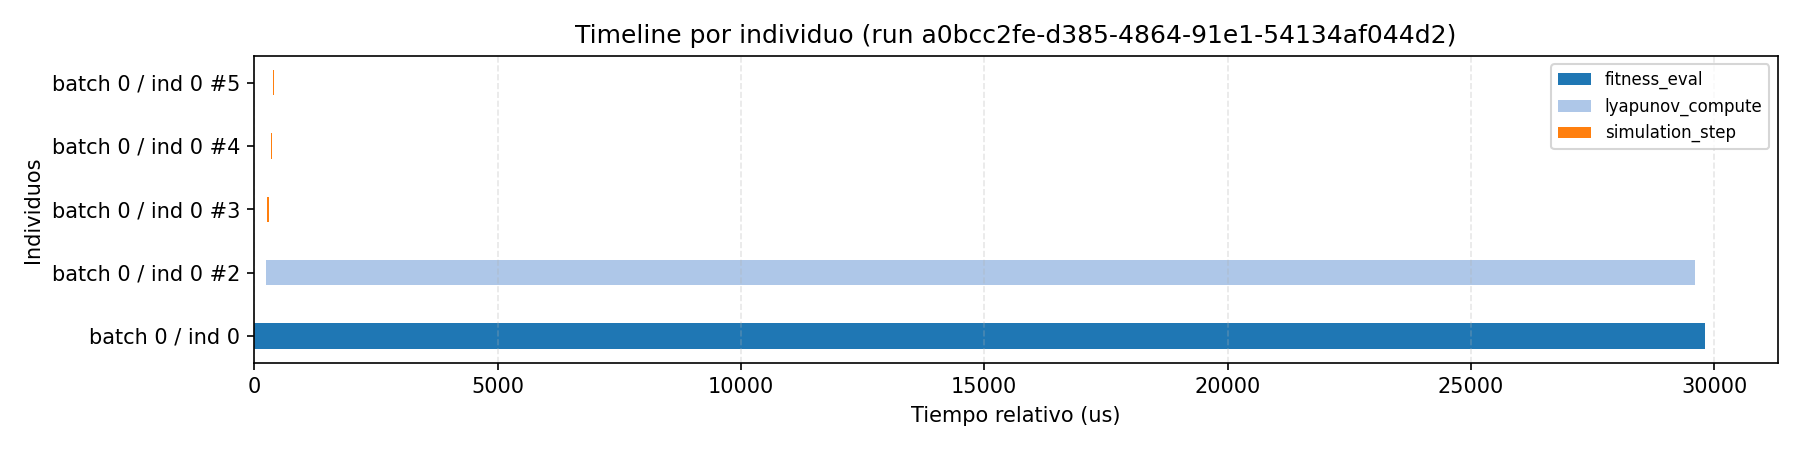

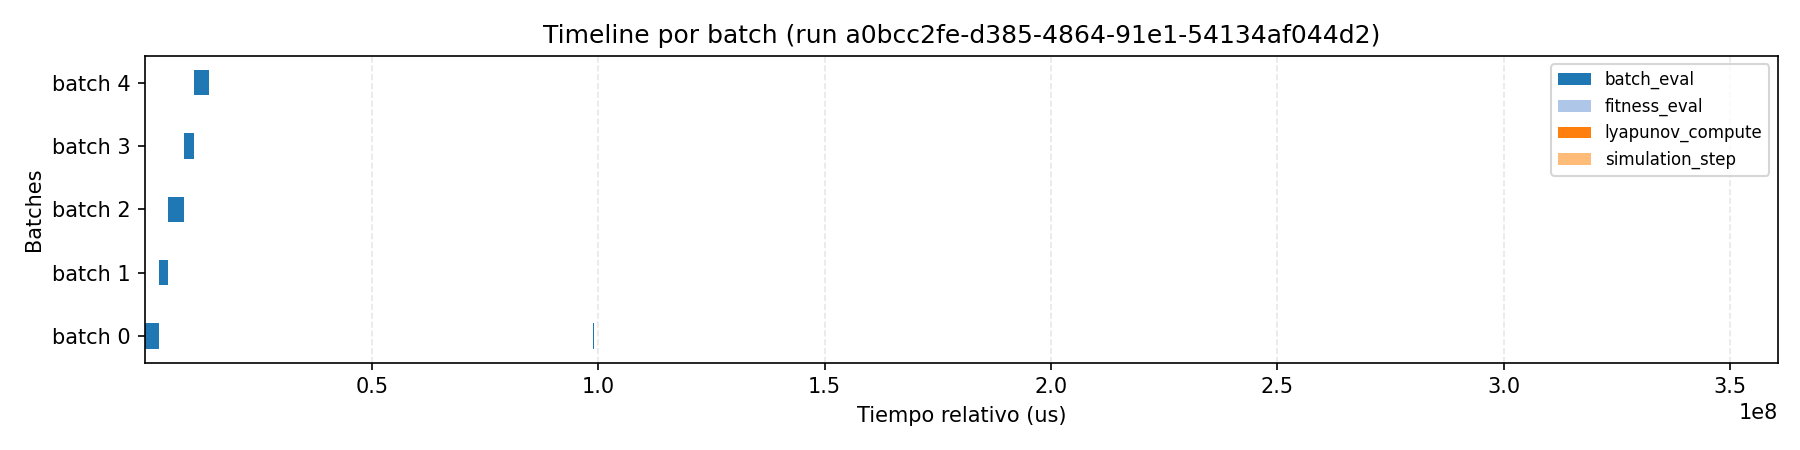

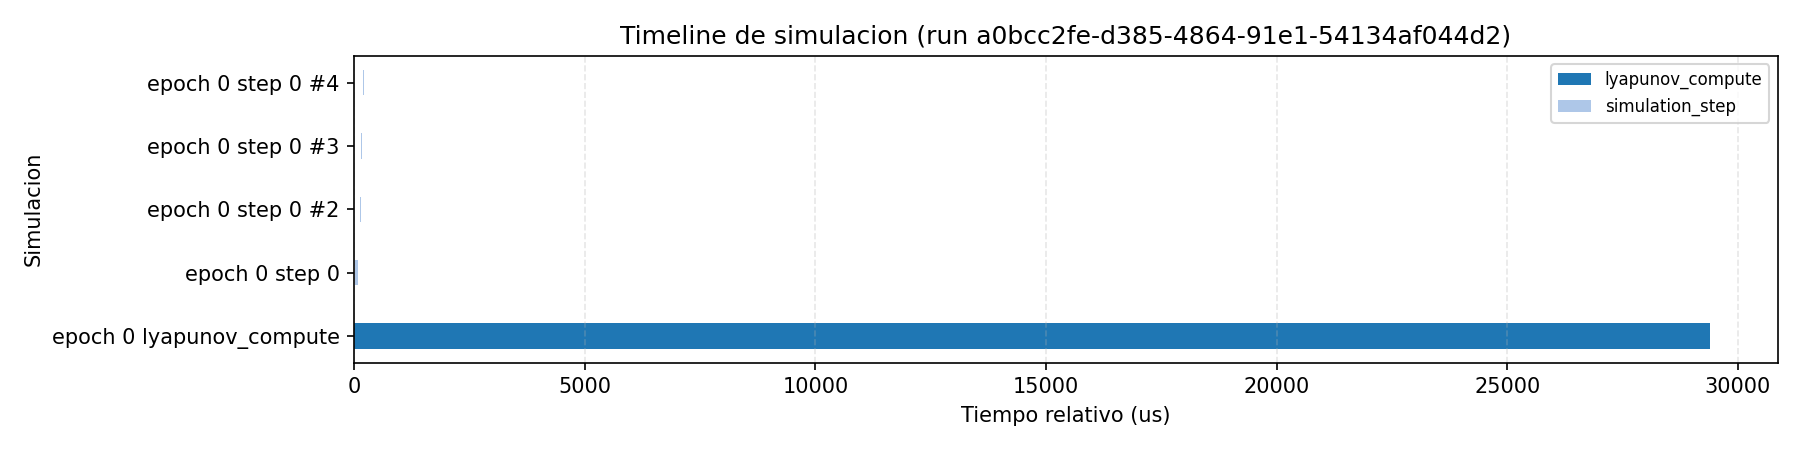

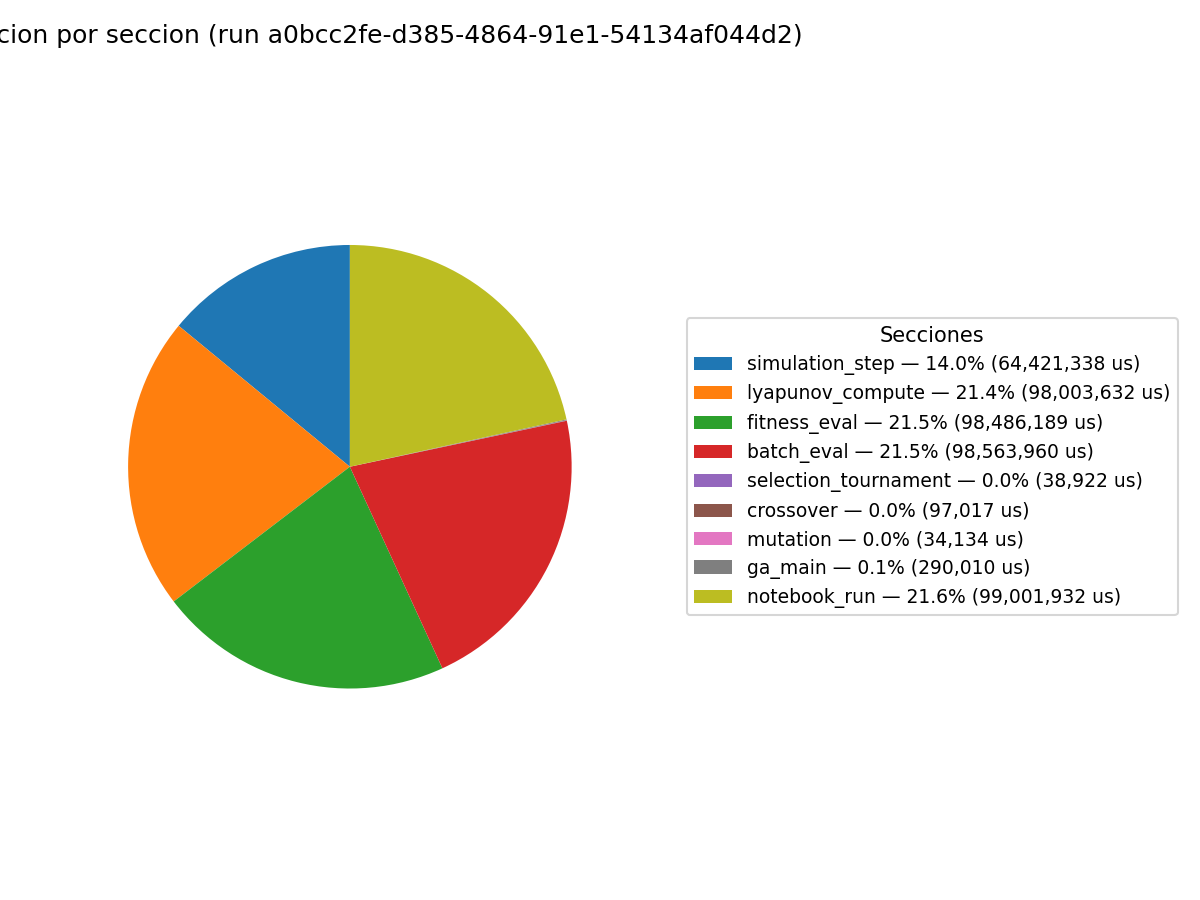

In [ ]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"

display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)


In [ ]:
# from pathlib import Path
# 
# 
# output_path = Path("artifacts/animations/caso01_orbit.gif")
# output_path2 = Path("artifacts/animations/caso01_comparasion.gif")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# 
# anim.save(
#     output_path,
#     writer="pillow",
#     fps=20,
#     dpi=100,          # opcional
# )
# 
# print(f"Animación 3D guardada en {output_path}")
# 